In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Thesis

/content/drive/MyDrive/Thesis


In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from multiprocessing import cpu_count

import cv2
import glob
import importlib
import os
import joblib
import time

import gc



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
import os
ROOT_DIR = "/content/drive/MyDrive/Thesis/BreaKHis"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)) )

In [ ]:
import tensorflow as tf
img_height,img_width=244,244
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Thesis/BreaKHis/Train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3758 files belonging to 2 classes.
Using 3007 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Thesis/BreaKHis/Test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 536 files belonging to 2 classes.
Using 107 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


In [ ]:
class_names = val_ds.class_names
print(class_names)

['Benign', 'Malignant']


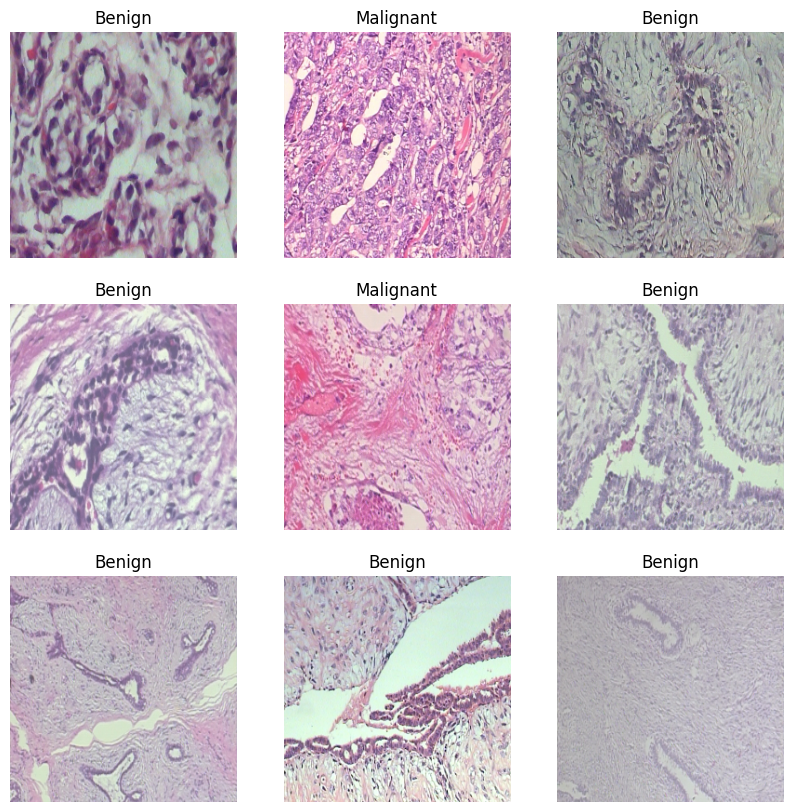

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

2.Data preprocessing

2.1.For malignant cell


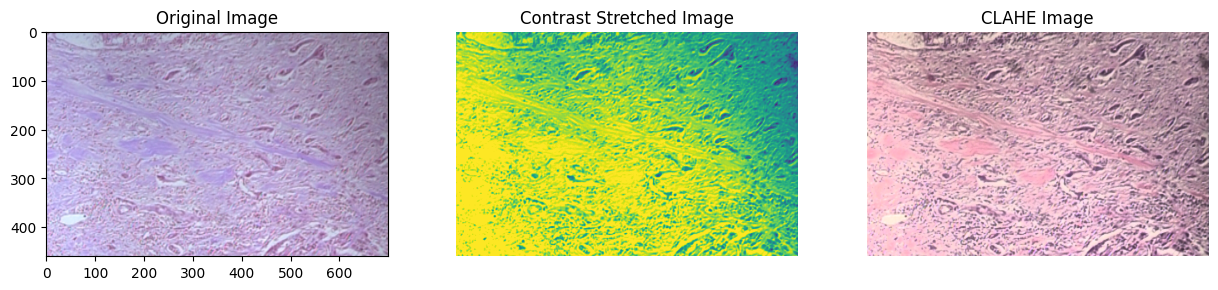

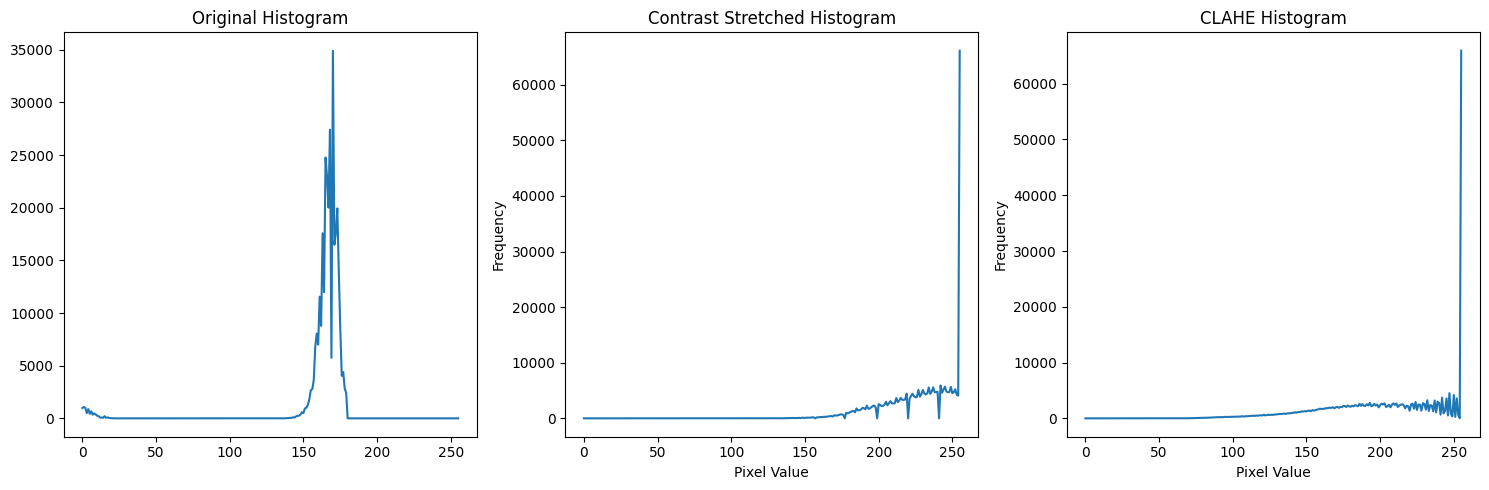

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Malignant/SOB_M_DC-14-10926-40-002.png'
image = cv2.imread(image_path)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Split the channels
h, s, v = cv2.split(hsv_image)

# Apply contrast stretching
contrast_stretched_image = cv2.convertScaleAbs(v, alpha=1.05, beta=20)


# Apply CLAHE on the Value channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_v = clahe.apply(contrast_stretched_image)

# Merge the channels back into an HSV image
processed_hsv_image = cv2.merge([h, s, clahe_v])

# Convert the HSV image back to RGB
processed_rgb_image = cv2.cvtColor(processed_hsv_image, cv2.COLOR_HSV2RGB)


# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(contrast_stretched_image)
plt.title('Contrast Stretched Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(processed_rgb_image)
plt.title('CLAHE Image')
plt.axis('off')

# Plot histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cv2.calcHist([hsv_image], [0], None, [256], [0, 256]))
plt.title('Original Histogram')

plt.subplot(1, 3, 2)
plt.plot(cv2.calcHist([contrast_stretched_image], [0], None, [256], [0, 256]))
plt.title('Contrast Stretched Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(cv2.calcHist([processed_rgb_image], [0], None, [256], [0, 256]))
plt.title('CLAHE Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



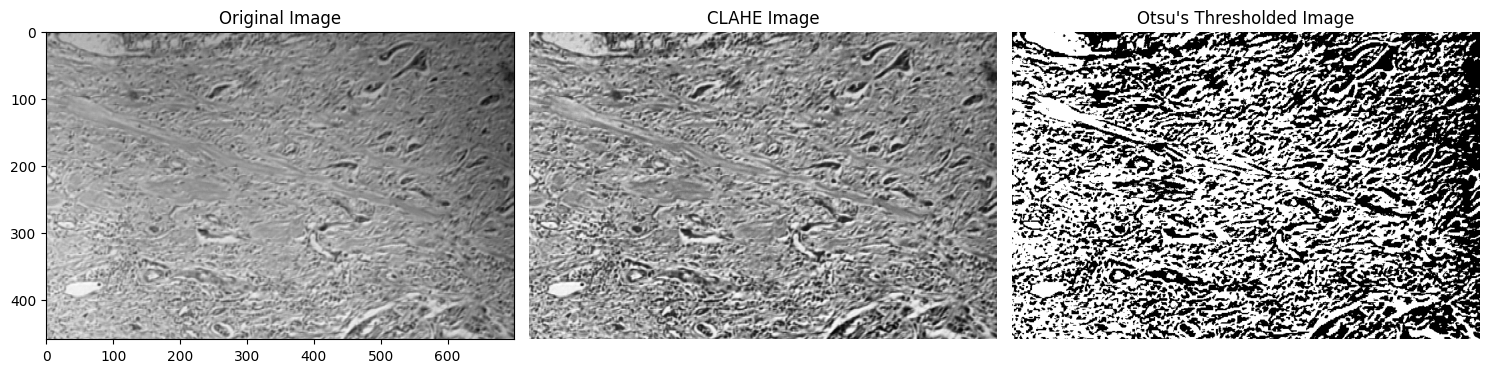

In [ ]:
#Segmentation: before applying Gaussian Blur
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Malignant/SOB_M_DC-14-10926-40-002.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(image)

# Apply Otsu's thresholding
_, thresholded_image = cv2.threshold(clahe_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Otsu's Thresholded Image")
plt.axis('off')

plt.tight_layout()
plt.show()

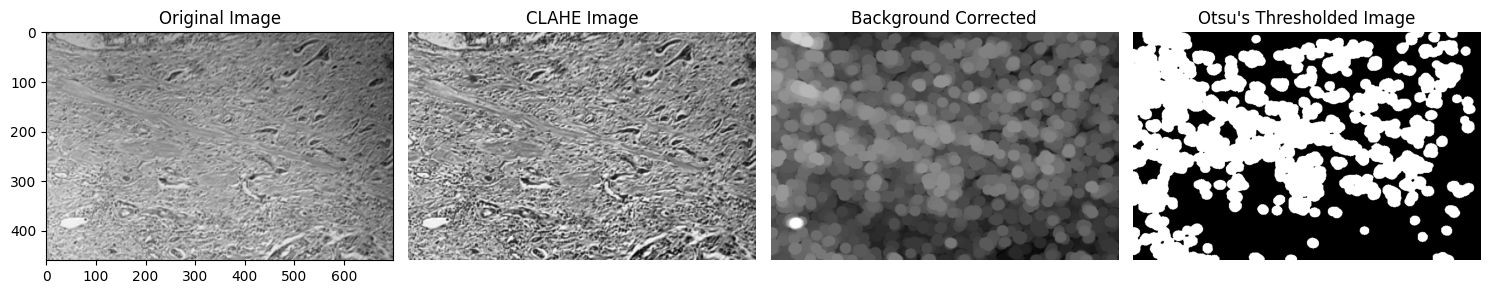

In [ ]:
#Segmentation: after applying Gaussian Blur
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

# Load the image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Malignant/SOB_M_DC-14-10926-40-002.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(image)

# Background correction using morphological opening
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)

# Apply Gaussian blur for noise reduction
filtered_image = cv2.GaussianBlur(background_corrected, (5, 5), 0)

# Apply Otsu's thresholding
_, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(background_corrected, cmap='gray')
plt.title('Background Corrected')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Otsu's Thresholded Image")
plt.axis('off')

plt.tight_layout()
plt.show()


2.2.For benign cell

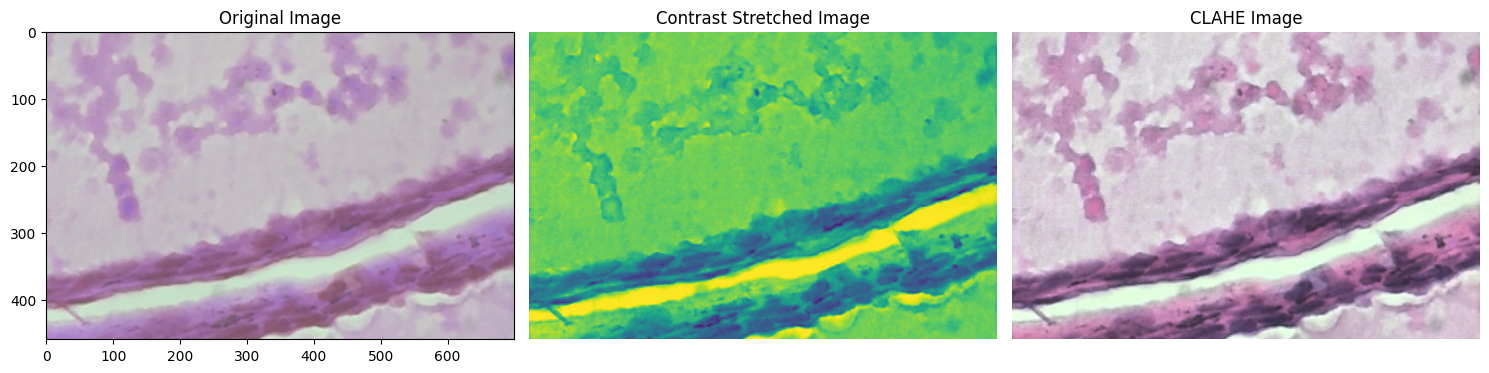

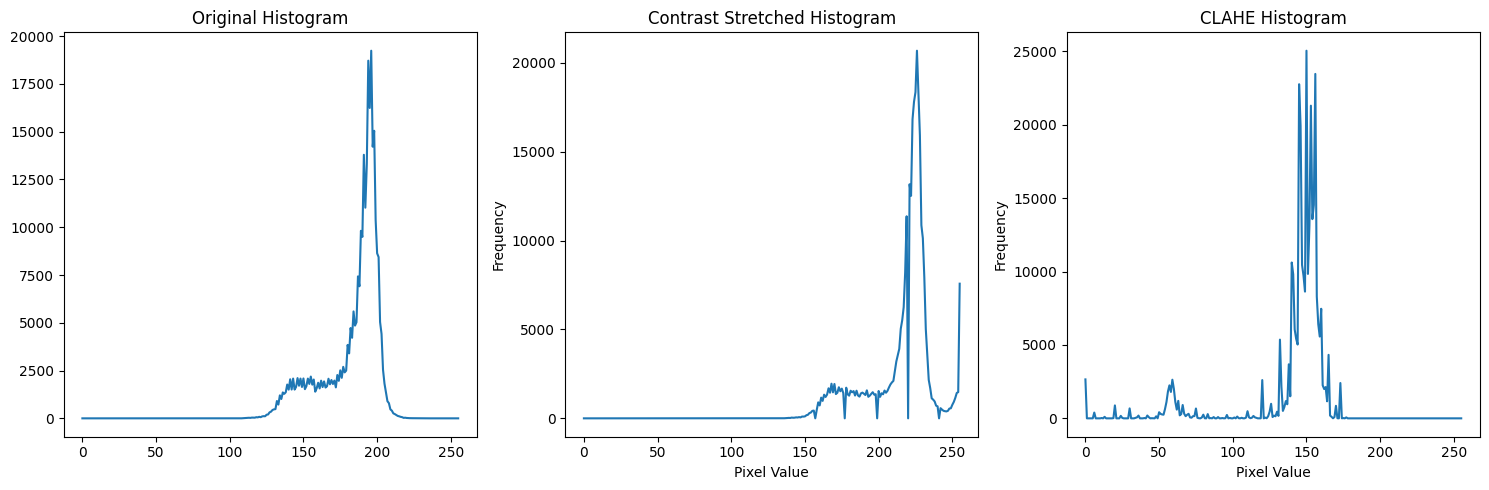

In [ ]:
#Color image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Benign/SOB_B_A-14-22549AB-400-016.png'
image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Split the channels
h, s, v = cv2.split(hsv_image)

# Apply contrast stretching
contrast_stretched_image = cv2.convertScaleAbs(v, alpha=1.05, beta=20)
contrast_rgb_image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

# Apply CLAHE on the Value channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_v = clahe.apply(contrast_stretched_image)

# Merge the channels back into an HSV image
processed_hsv_image = cv2.merge([h, s, clahe_v])

# Convert the HSV image back to RGB
processed_rgb_image = cv2.cvtColor(processed_hsv_image, cv2.COLOR_HSV2RGB)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(contrast_stretched_image)
plt.title('Contrast Stretched Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(processed_rgb_image)
plt.title('CLAHE Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cv2.calcHist([image], [0], None, [256], [0, 256]))
plt.title('Original Histogram')

plt.subplot(1, 3, 2)
plt.plot(cv2.calcHist([contrast_stretched_image], [0], None, [256], [0, 256]))
plt.title('Contrast Stretched Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(cv2.calcHist([processed_hsv_image], [0], None, [256], [0, 256]))
plt.title('CLAHE Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


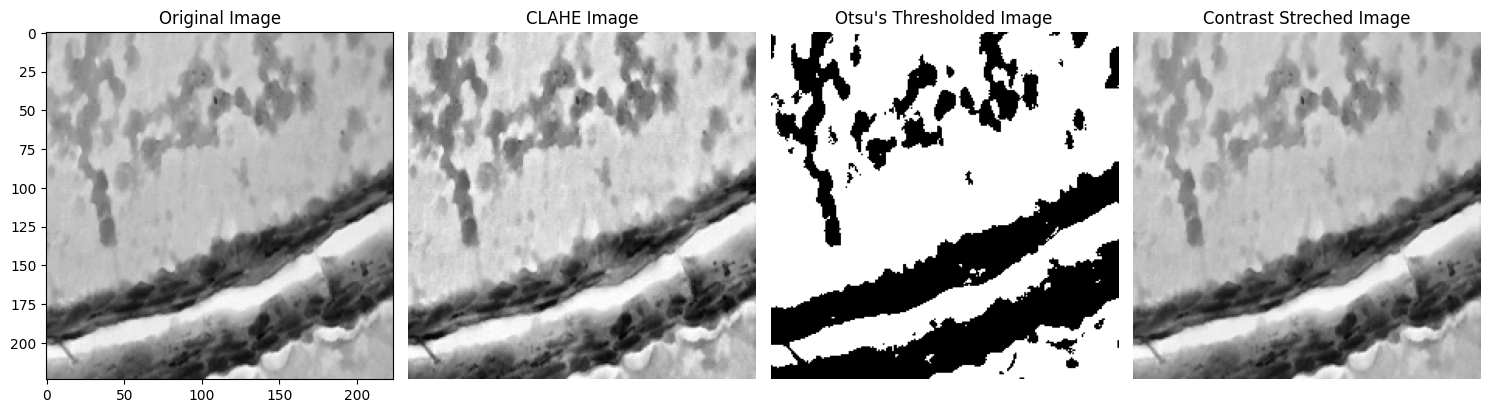

In [ ]:
#Segmentation: before applying Gaussian Blur
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Benign/SOB_B_A-14-22549AB-400-016.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image
resized_image = cv2.resize(image, (224, 224))

# Apply contrast stretching using convertScaleAbs function
contrast_stretched_image = cv2.convertScaleAbs(resized_image, alpha=1.05, beta=20)

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(contrast_stretched_image)


# Apply Otsu's thresholding
_, thresholded_image = cv2.threshold(clahe_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(resized_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Otsu's Thresholded Image")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(contrast_stretched_image, cmap='gray')
plt.title("Contrast Streched Image")
plt.axis('off')

plt.tight_layout()
plt.show()

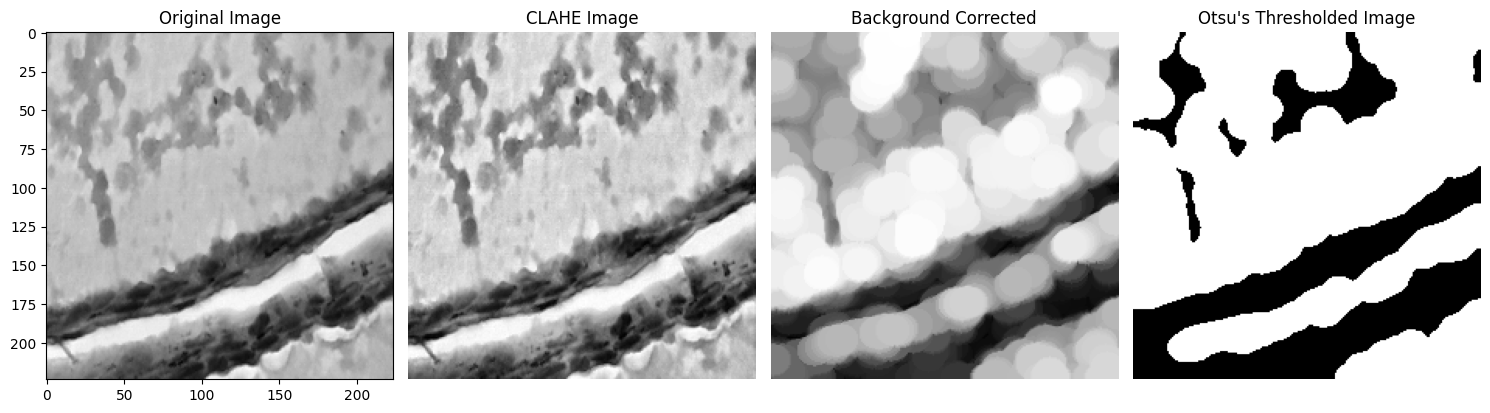

In [ ]:
#Segmentation: after applying Gaussian Blur
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Benign/SOB_B_A-14-22549AB-400-016.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image
resized_image = cv2.resize(image, (224, 224))

# Apply contrast stretching using convertScaleAbs function
contrast_stretched_image = cv2.convertScaleAbs(resized_image, alpha=1.05, beta=20)

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(contrast_stretched_image)

# Background correction using morphological opening
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)

# Apply Gaussian blur for noise reduction
filtered_image = cv2.GaussianBlur(background_corrected, (5, 5), 0)

# Apply Otsu's thresholding
_, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(resized_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(background_corrected, cmap='gray')
plt.title('Background Corrected')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Otsu's Thresholded Image")
plt.axis('off')

plt.tight_layout()
plt.show()


3.Segmentation

3.Segmented Malignant cells for training

In [ ]:
import cv2
import os

input_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Malignant'
output_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Malignant'


os.makedirs(output_folder, exist_ok=True)

image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))
               and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.JPG'))]


for image_file in image_files:

    image = cv2.imread(os.path.join(input_folder, image_file), cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching
    contrast_stretched_image = cv2.convertScaleAbs(image, alpha=1.05, beta=20)

   # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(contrast_stretched_image)

    # Background correction using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)


    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Save the segmented image
    output_file = os.path.join(output_folder, image_file)
    cv2.imwrite(output_file, segmented_image)

In [ ]:
import cv2
import os

# Input and output folders
input_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Train/Benign'
output_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Benign'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get the list of image files from the input folder
image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))
               and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.JPG'))]

# Iterate through each image file
for image_file in image_files:
    # Read the image
    image = cv2.imread(os.path.join(input_folder, image_file), cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching using convertScaleAbs function
    contrast_stretched_image = cv2.convertScaleAbs(image, alpha=1.05, beta=20)

   # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(contrast_stretched_image)

    # Background correction using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)


    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Save the segmented image to the output folder
    output_file = os.path.join(output_folder, image_file)
    cv2.imwrite(output_file, segmented_image)

Segmented cells for testing

In [ ]:
import cv2
import os


input_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Test/Malignant'
output_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test_Malignant'


os.makedirs(output_folder, exist_ok=True)


image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))
               and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.JPG'))]


for image_file in image_files:

    image = cv2.imread(os.path.join(input_folder, image_file), cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching using convertScaleAbs function
    contrast_stretched_image = cv2.convertScaleAbs(image, alpha=1.05, beta=20)

   # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(contrast_stretched_image)

    # Background correction using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)


    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    output_file = os.path.join(output_folder, image_file)
    cv2.imwrite(output_file, segmented_image)

In [ ]:
import cv2
import os


input_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Test/Benign'
output_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test_Benign'


os.makedirs(output_folder, exist_ok=True)


image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))
               and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.JPG'))]


for image_file in image_files:

    image = cv2.imread(os.path.join(input_folder, image_file), cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching using convertScaleAbs function
    contrast_stretched_image = cv2.convertScaleAbs(image, alpha=1.05, beta=20)

   # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(contrast_stretched_image)

    # Background correction using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)


    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    output_file = os.path.join(output_folder, image_file)
    cv2.imwrite(output_file, segmented_image)

Segmented cells for val

In [ ]:
import cv2
import os


input_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Val/Malignant'
output_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Val_Malignant'


os.makedirs(output_folder, exist_ok=True)


image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))
               and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.JPG'))]


for image_file in image_files:

    image = cv2.imread(os.path.join(input_folder, image_file), cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching using convertScaleAbs function
    contrast_stretched_image = cv2.convertScaleAbs(image, alpha=1.05, beta=20)

   # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(contrast_stretched_image)

    # Background correction using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)


    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    output_file = os.path.join(output_folder, image_file)
    cv2.imwrite(output_file, segmented_image)

In [ ]:
import cv2
import os


input_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Val/Benign'
output_folder = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Val_Benign'


os.makedirs(output_folder, exist_ok=True)


image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))
               and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.JPG'))]


for image_file in image_files:

    image = cv2.imread(os.path.join(input_folder, image_file), cv2.IMREAD_GRAYSCALE)

    # Apply contrast stretching using convertScaleAbs function
    contrast_stretched_image = cv2.convertScaleAbs(image, alpha=1.05, beta=20)

   # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(contrast_stretched_image)

    # Background correction using morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    background_corrected = cv2.morphologyEx(clahe_image, cv2.MORPH_OPEN, kernel)


    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    output_file = os.path.join(output_folder, image_file)
    cv2.imwrite(output_file, segmented_image)

4.Feature Extraction:LBP

4.1.one malignant image

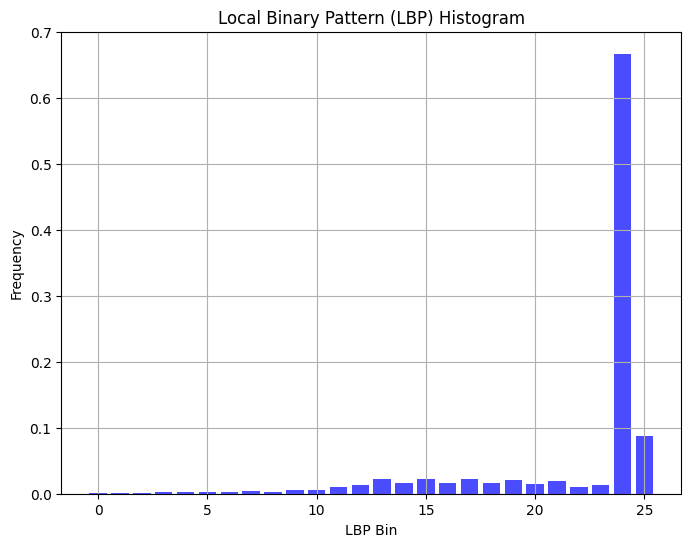

In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# Function to extract LBP features from a segmented image
def extract_lbp_features(image, num_points=24, radius=8):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute Local Binary Pattern (LBP) features
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')

    # Calculate histogram of LBP features
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist

# Load the segmented image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test_Malignant/SOB_M_DC-14-10926-400-005.png'
segmented_image = cv2.imread(image_path)


if segmented_image is None:
    print("Error: Unable to load the image. Please verify the file path.")
else:

    lbp_features = extract_lbp_features(segmented_image)

    # Plot the LBP histogram
    plt.figure(figsize=(8, 6))
    plt.bar(np.arange(len(lbp_features)), lbp_features, color='b', alpha=0.7)
    plt.xlabel('LBP Bin')
    plt.ylabel('Frequency')
    plt.title('Local Binary Pattern (LBP) Histogram')
    plt.grid(True)
    plt.show()



4.2.one benign image

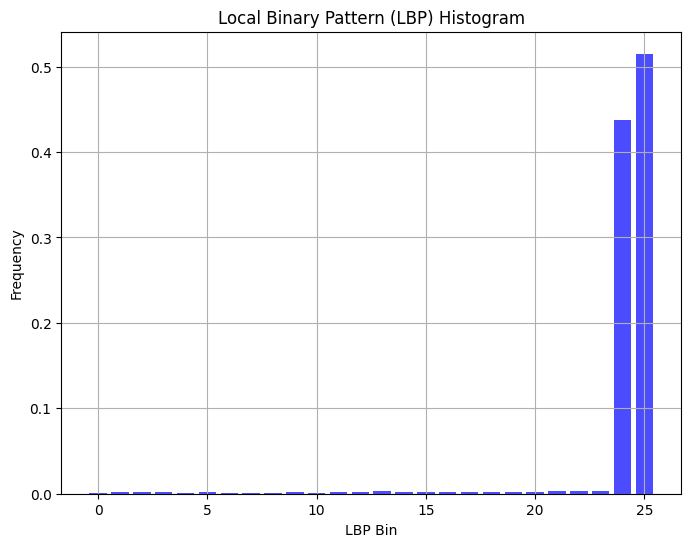

In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# Function to extract LBP features from a segmented image
def extract_lbp_features(image, num_points=24, radius=8):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute Local Binary Pattern (LBP) features
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')

    # Calculate histogram of LBP features
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist

# Load the segmented image
image_path = '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Benign/SOB_B_F-14-23060CD-40-003.png'
segmented_image = cv2.imread(image_path)

# Check if the image was loaded successfully
if segmented_image is None:
    print("Error: Unable to load the image. Please verify the file path.")
else:
    # Extract LBP features from the segmented image
    lbp_features = extract_lbp_features(segmented_image)

    # Plot the LBP histogram
    plt.figure(figsize=(8, 6))
    plt.bar(np.arange(len(lbp_features)), lbp_features, color='b', alpha=0.7)
    plt.xlabel('LBP Bin')
    plt.ylabel('Frequency')
    plt.title('Local Binary Pattern (LBP) Histogram')
    plt.grid(True)
    plt.show()


4.3.Seg_all images

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

# Function to extract LBP features from an image
def extract_lbp_features(image, num_points=24, radius=8):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute Local Binary Pattern (LBP) features
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')

    # Calculate histogram of LBP features
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist

# Directory paths containing segmented images
directories = [
    '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Benign',
    '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Malignant',
    '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test_Benign',
    '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test_Malignant',
    '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Val_Benign',
    '/content/drive/MyDrive/Thesis/BreaKHis/Seg_Val_Malignant'
]

# List to store extracted features and labels
all_features = []
all_labels = []

# Loop through each directory
for directory in directories:
    # Get the label from the directory name
    label = directory.split('/')[-1]  # Extract the label from the directory path

    # Loop through segmented images in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Read the image
            image = cv2.imread(os.path.join(directory, filename))

            # Extract features from the image
            lbp_features = extract_lbp_features(image)

            # Append features and label
            all_features.append(lbp_features)
            all_labels.append(label)

# Convert features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Standardize the features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)




Model1:EfficientNetB3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
# name the labels
labels=['Seg_Benign','Seg_Malignant']

In [ ]:
# load the images

X_full = []
y_full = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 2022/2022 [00:41<00:00, 48.95it/s] 


In [ ]:
#label encoding

y_full_new = []
for i in y_full:
    y_full_new.append(labels.index(i))
y_full = y_full_new
y_full = tf.keras.utils.to_categorical(y_full)

In [ ]:
#train test split

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.3,random_state=10)

5.Data splitting:Train 70%, Val 20% ,Test 10%

In [ ]:
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential



base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential()


model.add(base_model)


model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='/content/drive/MyDrive/Thesis/best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, verbose=1,callbacks=checkpoint)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.2079 - accuracy: 0.5248
Epoch 1: val_accuracy improved from -inf to 0.58340, saving model to /content/drive/MyDrive/Thesis/best_model.h5
47/47 [==============================] - 132s 3s/step - loss: 1.2079 - accuracy: 0.5248 - val_loss: 0.6626 - val_accuracy: 0.5834
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.5987
Epoch 2: val_accuracy improved from 0.58340 to 0.65012, saving model to /content/drive/MyDrive/Thesis/best_model.h5
47/47 [==============================] - 119s 3s/step - loss: 0.9978 - accuracy: 0.5987 - val_loss: 0.6339 - val_accuracy: 0.6501
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.5960
Epoch 3: val_accuracy improved from 0.65012 to 0.66175, saving model to /content/drive/MyDrive/Thesis/best_model.h5
47/47 [==============================] - 119s 3s

In [ ]:
from keras.models import load_model

filepath='/content/drive/MyDrive/Thesis/best_model.h5'

In [ ]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, y_train)
print('Train accuracy:', train_acc)

94/94 [==============================] - 118s 1s/step - loss: 0.2868 - accuracy: 0.8829
Train accuracy: 0.8828619122505188


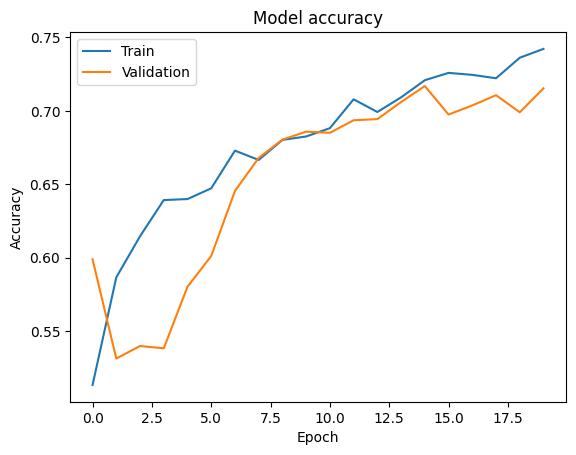

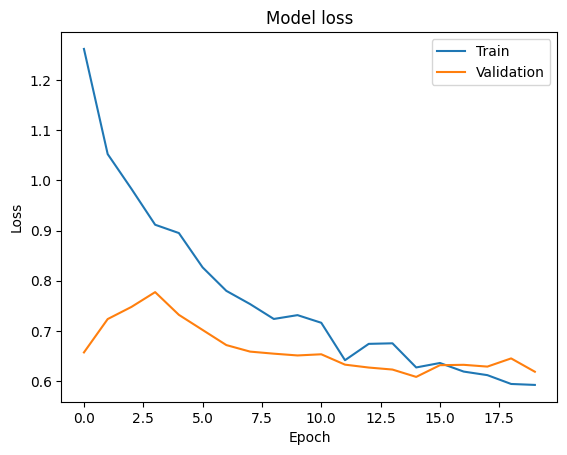

41/41 [==============================] - 49s 1s/step - loss: 0.6188 - accuracy: 0.7153
Train Accuracy: 88.28619122505188
Test Accuracy: 71.52831554412842
41/41 [==============================] - 49s 1s/step
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1361
           1       0.93      0.85      0.89      1644

    accuracy                           0.88      3005
   macro avg       0.88      0.89      0.88      3005
weighted avg       0.89      0.88      0.88      3005

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.68      0.77      0.72       623
           1       0.75      0.67      0.71       666

    accuracy                           0.72      1289
   macro avg       0.72      0.72      0.72      1289
weighted avg       0.72      0.72      0.71      1289



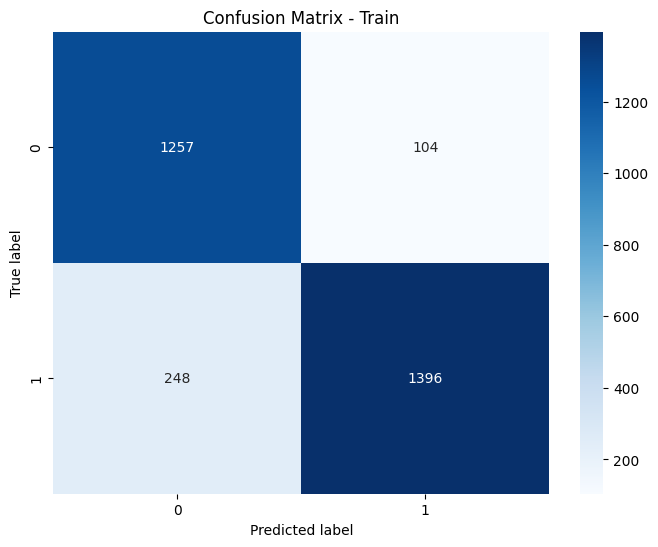

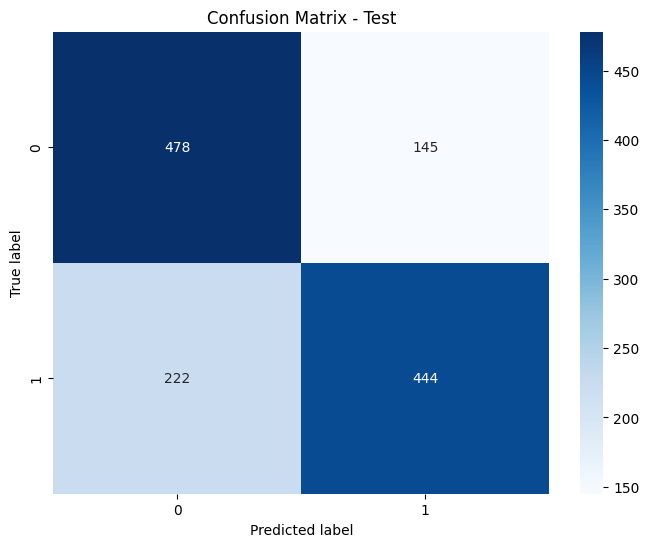

41/41 [==============================] - 46s 1s/step


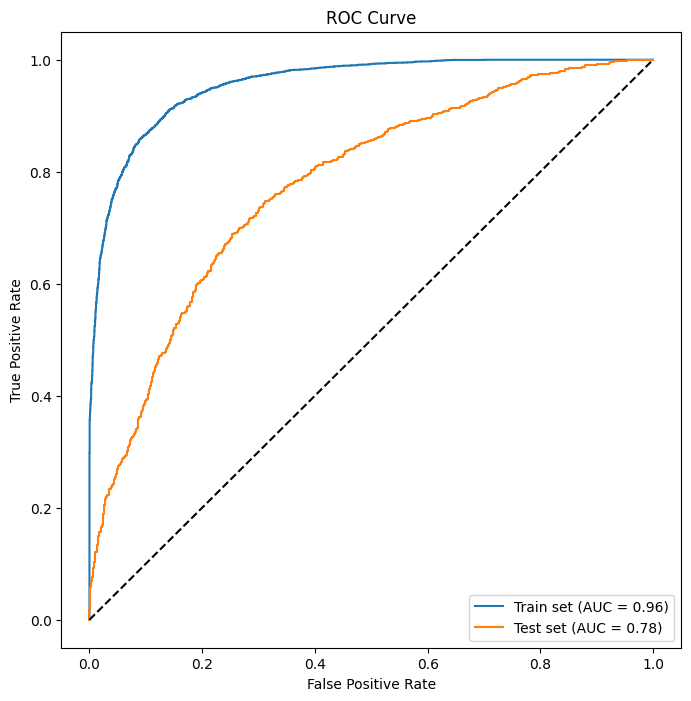

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)
train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list

# Print the evaluation results
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print classification report
pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Train):\n", classification_report(np.argmax(y_train, axis=1), pred_train))
print("Classification Report (Test):\n", classification_report(np.argmax(y_test, axis=1), pred_test))

# Calculate confusion matrix
cm_train = confusion_matrix(np.argmax(y_train, axis=1), pred_train)
cm_test = confusion_matrix(np.argmax(y_test, axis=1), pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC curve
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train set (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# New Section

Model2:ResNet50

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
# name the labels
labels=['Seg_Benign','Seg_Malignant']

In [ ]:
# load the images

X_full = []
y_full = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 2022/2022 [01:19<00:00, 25.43it/s]


In [ ]:
#label encoding

y_full_new = []
for i in y_full:
    y_full_new.append(labels.index(i))
y_full = y_full_new
y_full = tf.keras.utils.to_categorical(y_full)

In [ ]:
#train test split

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.3,random_state=10)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(base_model)

# Add custom layers on top of the base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(patience=3, monitor='val_loss')
filepath = '/content/drive/MyDrive/Thesis/best_model1.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, verbose=1, callbacks=[checkpoint, es])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.1307 - accuracy: 0.5734
Epoch 1: val_accuracy improved from -inf to 0.60047, saving model to /content/drive/MyDrive/Thesis/best_model1.h5
47/47 [==============================] - 275s 6s/step - loss: 1.1307 - accuracy: 0.5734 - val_loss: 0.7282 - val_accuracy: 0.6005
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.9940 - accuracy: 0.6126
Epoch 2: val_accuracy improved from 0.60047 to 0.66175, saving model to /content/drive/MyDrive/Thesis/best_model1.h5
47/47 [==============================] - 262s 6s/step - loss: 0.9940 - accuracy: 0.6126 - val_loss: 0.6702 - val_accuracy: 0.6618
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.6546
Epoch 3: val_accuracy improved from 0.66175 to 0.70985, saving model to /content/drive/MyDrive/Thesis/best_model1.h5
47/47 [==============================] - 256s 5s/step - loss: 0.8825 - accuracy: 0.6546 - val_loss: 0.5950 - v

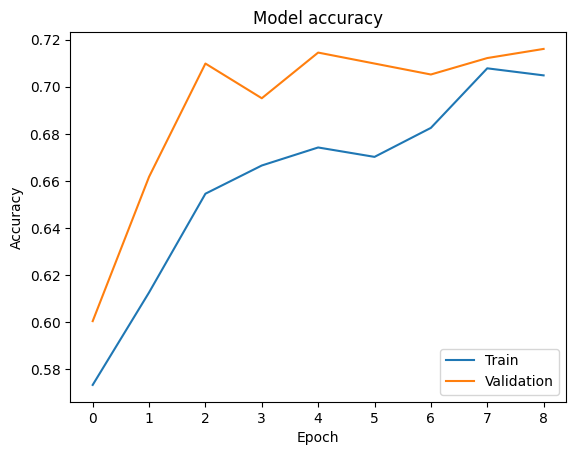

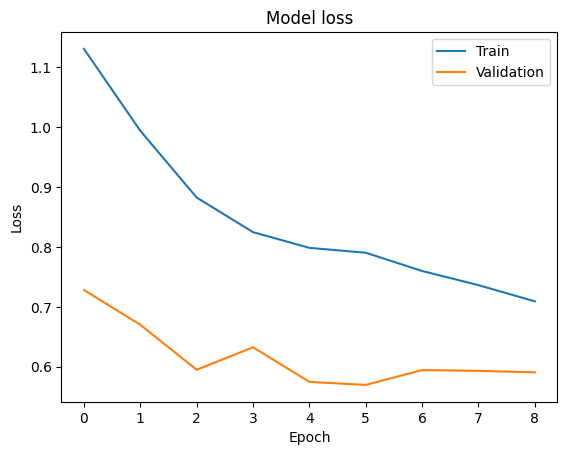

41/41 [==============================] - 69s 2s/step - loss: 0.5907 - accuracy: 0.7161
Train Accuracy: 80.23294806480408
Test Accuracy: 71.60589694976807
41/41 [==============================] - 69s 2s/step
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      1361
           1       0.80      0.85      0.82      1644

    accuracy                           0.80      3005
   macro avg       0.80      0.80      0.80      3005
weighted avg       0.80      0.80      0.80      3005

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.73      0.65      0.69       623
           1       0.70      0.78      0.74       666

    accuracy                           0.72      1289
   macro avg       0.72      0.71      0.71      1289
weighted avg       0.72      0.72      0.71      1289



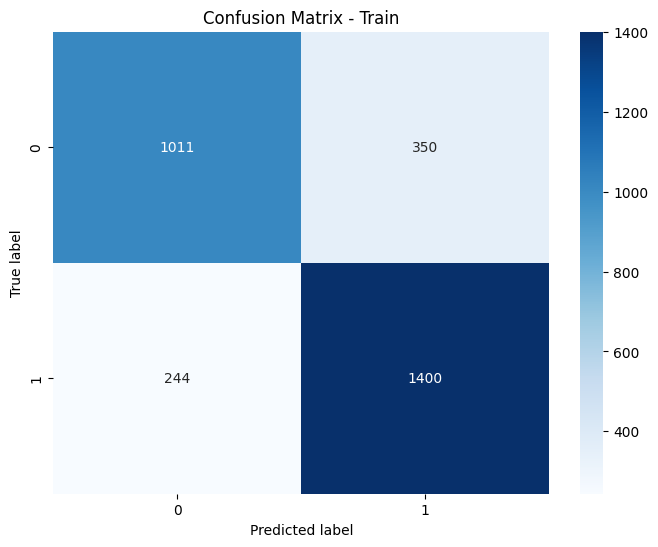

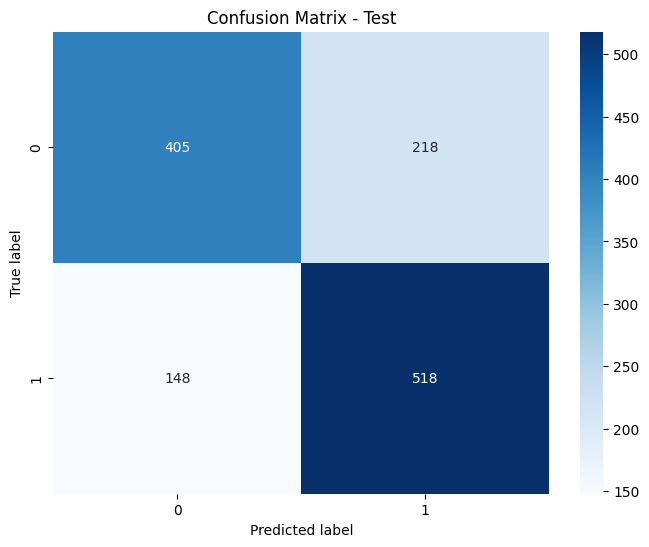

41/41 [==============================] - 69s 2s/step


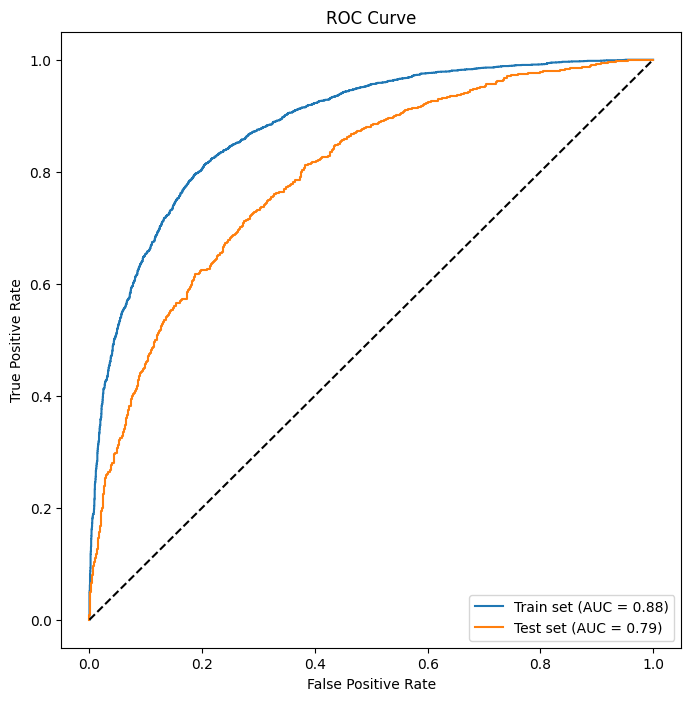

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)
train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list

# Print the evaluation results
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print classification report
pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Train):\n", classification_report(np.argmax(y_train, axis=1), pred_train))
print("Classification Report (Test):\n", classification_report(np.argmax(y_test, axis=1), pred_test))

# Calculate confusion matrix
cm_train = confusion_matrix(np.argmax(y_train, axis=1), pred_train)
cm_test = confusion_matrix(np.argmax(y_test, axis=1), pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC curve
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train set (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Model1 plotting

Model3:ResNet101

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
# name the labels
labels=['Seg_Benign','Seg_Malignant']

In [ ]:
# load the images

X_full = []
y_full = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 2022/2022 [00:51<00:00, 38.92it/s] 


In [ ]:
#label encoding

y_full_new = []
for i in y_full:
    y_full_new.append(labels.index(i))
y_full = y_full_new
y_full = tf.keras.utils.to_categorical(y_full)

In [ ]:
#train test split

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.3,random_state=10)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.applications import ResNet101
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

# Load pre-trained ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet101 base model
model.add(base_model)

# Add custom layers on top of the base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(patience=3, monitor='val_loss')
filepath = '/content/drive/MyDrive/Thesis/best_model2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, verbose=1, callbacks=[checkpoint, es])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.0456 - accuracy: 0.5561
Epoch 1: val_accuracy improved from -inf to 0.66175, saving model to /content/drive/MyDrive/Thesis/best_model2.h5
47/47 [==============================] - 28s 331ms/step - loss: 1.0456 - accuracy: 0.5561 - val_loss: 0.6224 - val_accuracy: 0.6618
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.6349
Epoch 2: val_accuracy improved from 0.66175 to 0.67649, saving model to /content/drive/MyDrive/Thesis/best_model2.h5
47/47 [==============================] - 9s 202ms/step - loss: 0.8759 - accuracy: 0.6349 - val_loss: 0.6105 - val_accuracy: 0.6765
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.8102 - accuracy: 0.6622
Epoch 3: val_accuracy improved from 0.67649 to 0.69666, saving model to /content/drive/MyDrive/Thesis/best_model2.h5
47/47 [==============================] -

In [ ]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, y_train)
print('Train accuracy:', train_acc)

94/94 [==============================] - 6s 60ms/step - loss: 0.4765 - accuracy: 0.7724
Train accuracy: 0.7723793387413025


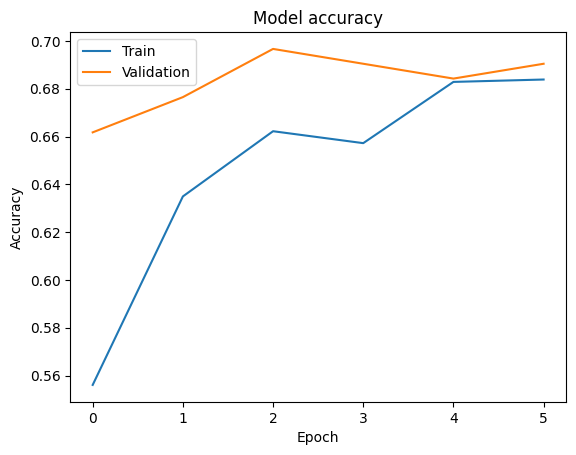

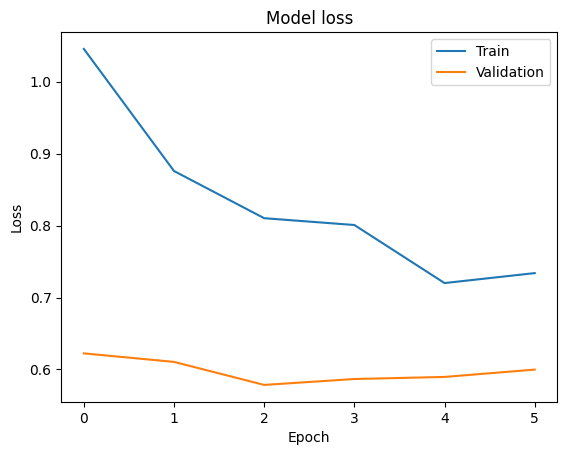

41/41 [==============================] - 2s 58ms/step - loss: 0.5998 - accuracy: 0.6905
Train Accuracy: 77.23793387413025
Test Accuracy: 69.04577016830444
41/41 [==============================] - 2s 57ms/step
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.81      0.65      0.72      1361
           1       0.75      0.87      0.81      1644

    accuracy                           0.77      3005
   macro avg       0.78      0.76      0.76      3005
weighted avg       0.78      0.77      0.77      3005

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.74      0.55      0.63       623
           1       0.66      0.82      0.73       666

    accuracy                           0.69      1289
   macro avg       0.70      0.69      0.68      1289
weighted avg       0.70      0.69      0.68      1289



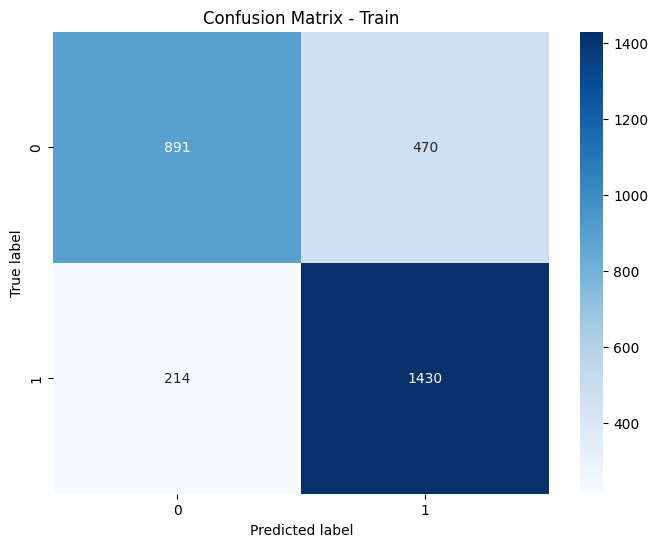

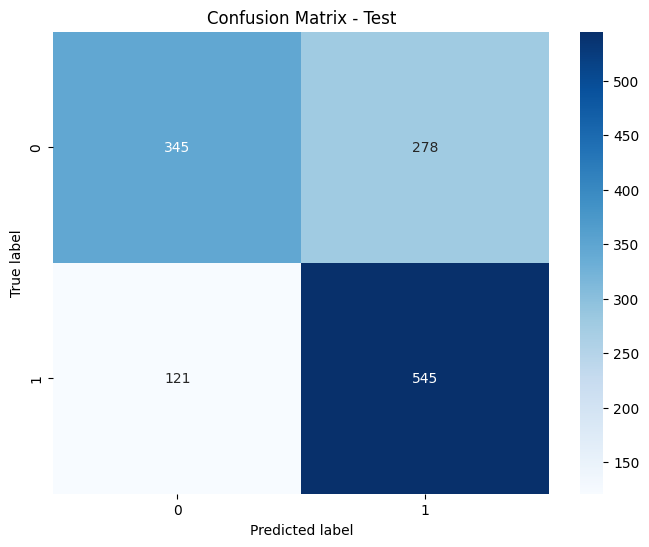

41/41 [==============================] - 2s 55ms/step


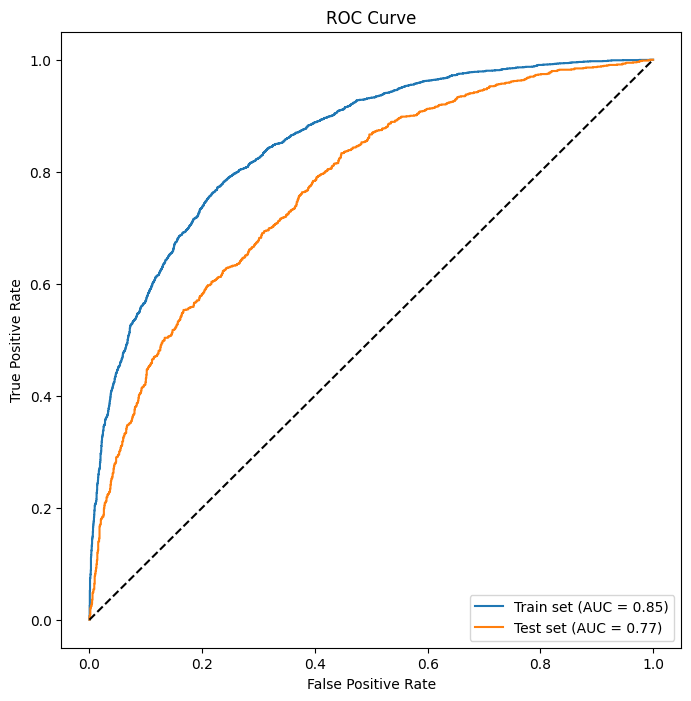

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)
train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list

# Print the evaluation results
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print classification report
pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Train):\n", classification_report(np.argmax(y_train, axis=1), pred_train))
print("Classification Report (Test):\n", classification_report(np.argmax(y_test, axis=1), pred_test))

# Calculate confusion matrix
cm_train = confusion_matrix(np.argmax(y_train, axis=1), pred_train)
cm_test = confusion_matrix(np.argmax(y_test, axis=1), pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC curve
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train set (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Model4:VGG16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
# name the labels
labels=['Seg_Benign','Seg_Malignant']

In [ ]:
# load the images

X_full = []
y_full = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 2022/2022 [00:33<00:00, 61.11it/s] 


In [ ]:
#label encoding

y_full_new = []
for i in y_full:
    y_full_new.append(labels.index(i))
y_full = y_full_new
y_full = tf.keras.utils.to_categorical(y_full)

In [ ]:
#train test split

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.3,random_state=10)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add custom layers on top of the base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(patience=3, monitor='val_loss')
filepath = '/content/drive/MyDrive/Thesis/best_model3.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, verbose=1, callbacks=[checkpoint, es])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.1738 - accuracy: 0.5358
Epoch 1: val_accuracy improved from -inf to 0.60978, saving model to /content/drive/MyDrive/Thesis/best_model3.h5
47/47 [==============================] - 23s 302ms/step - loss: 1.1738 - accuracy: 0.5358 - val_loss: 0.8155 - val_accuracy: 0.6098
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 1.0183 - accuracy: 0.5774
Epoch 2: val_accuracy improved from 0.60978 to 0.64624, saving model to /content/drive/MyDrive/Thesis/best_model3.h5
47/47 [==============================] - 7s 151ms/step - loss: 1.0183 - accuracy: 0.5774 - val_loss: 0.7252 - val_accuracy: 0.6462
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.6017
Epoch 3: val_accuracy improved from 0.64624 to 0.66098, saving model to /content/drive/MyDrive/Thesis/best_model3.h5
47/47 [==============================] - 7

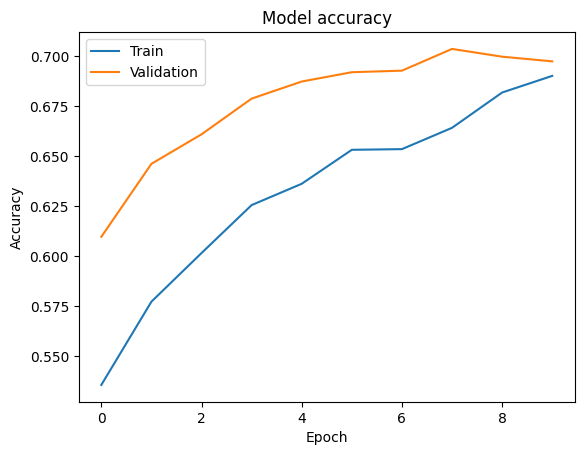

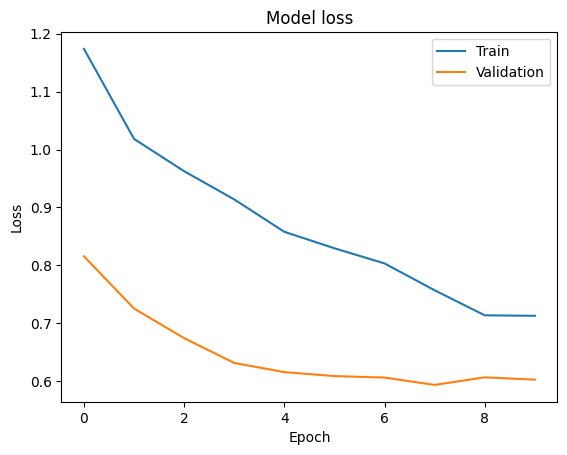

41/41 [==============================] - 2s 43ms/step - loss: 0.6023 - accuracy: 0.6974
Train Accuracy: 79.23460602760315
Test Accuracy: 69.74398493766785
41/41 [==============================] - 2s 44ms/step
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      0.68      0.75      1361
           1       0.77      0.89      0.82      1644

    accuracy                           0.79      3005
   macro avg       0.80      0.78      0.79      3005
weighted avg       0.80      0.79      0.79      3005

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.75      0.56      0.64       623
           1       0.67      0.83      0.74       666

    accuracy                           0.70      1289
   macro avg       0.71      0.69      0.69      1289
weighted avg       0.71      0.70      0.69      1289



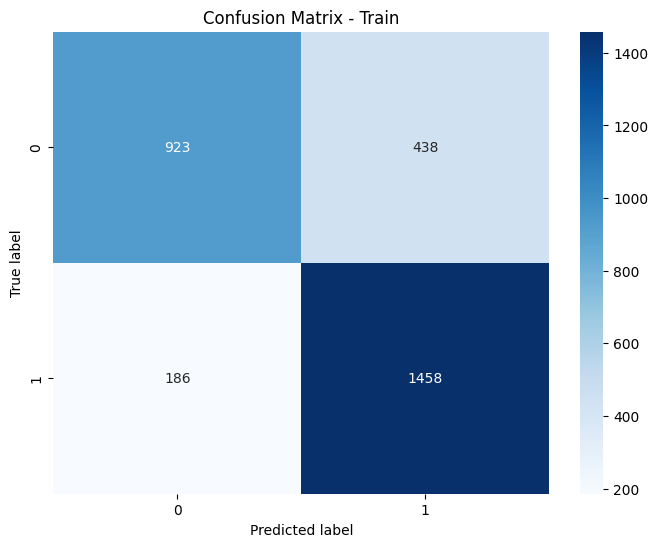

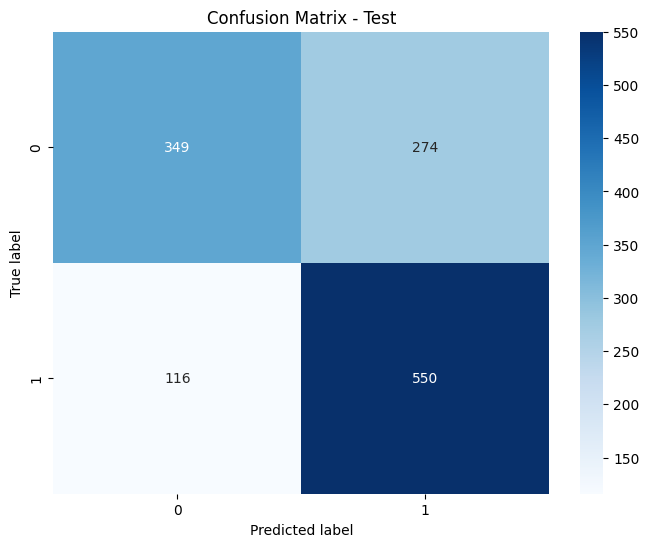

41/41 [==============================] - 2s 44ms/step


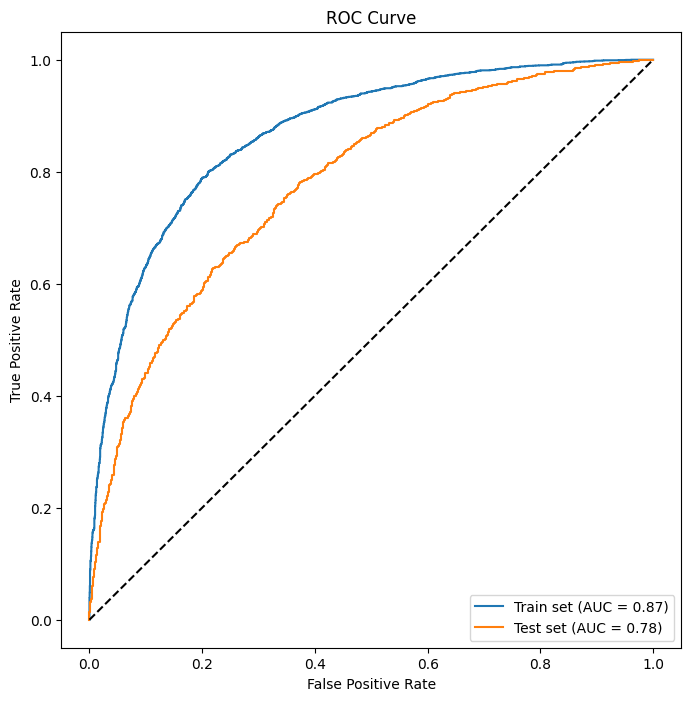

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)
train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list

# Print the evaluation results
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print classification report
pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Train):\n", classification_report(np.argmax(y_train, axis=1), pred_train))
print("Classification Report (Test):\n", classification_report(np.argmax(y_test, axis=1), pred_test))

# Calculate confusion matrix
cm_train = confusion_matrix(np.argmax(y_train, axis=1), pred_train)
cm_test = confusion_matrix(np.argmax(y_test, axis=1), pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC curve
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train set (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Model5:VGG19

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
# name the labels
labels=['Seg_Benign','Seg_Malignant']

In [ ]:
# load the images

X_full = []
y_full = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Thesis/BreaKHis/Seg_Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)


X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 2022/2022 [00:38<00:00, 52.77it/s] 


In [ ]:
#label encoding

y_full_new = []
for i in y_full:
    y_full_new.append(labels.index(i))
y_full = y_full_new
y_full = tf.keras.utils.to_categorical(y_full)

In [ ]:
#train test split

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.3,random_state=10)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.applications import VGG19
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the VGG19 base model
model.add(base_model)

# Add custom layers on top of the base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(patience=3, monitor='val_loss')
filepath = '/content/drive/MyDrive/Thesis/best_model4.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, verbose=1, callbacks=[checkpoint, es])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.5557
Epoch 1: val_accuracy improved from -inf to 0.61908, saving model to /content/drive/MyDrive/Thesis/best_model3.h5
47/47 [==============================] - 10s 181ms/step - loss: 1.0665 - accuracy: 0.5557 - val_loss: 0.8512 - val_accuracy: 0.6191
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 0.9219 - accuracy: 0.6077
Epoch 2: val_accuracy improved from 0.61908 to 0.65089, saving model to /content/drive/MyDrive/Thesis/best_model3.h5
47/47 [==============================] - 7s 159ms/step - loss: 0.9219 - accuracy: 0.6077 - val_loss: 0.7042 - val_accuracy: 0.6509
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.8756 - accuracy: 0.6286
Epoch 3: val_accuracy improved from 0.65089 to 0.66020, saving model to /content/drive/MyDrive/Thesis/best_model3.h5
47/47 [==============================] - 8

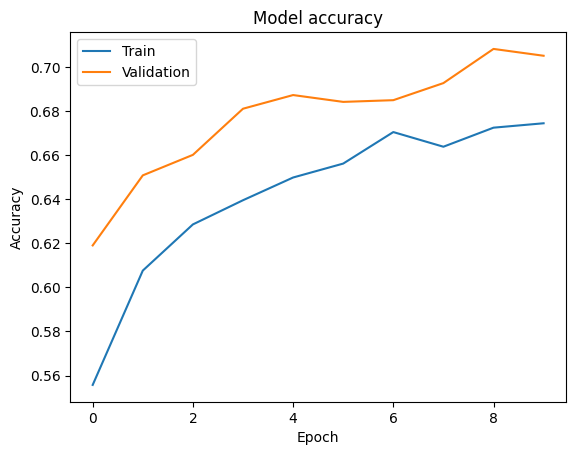

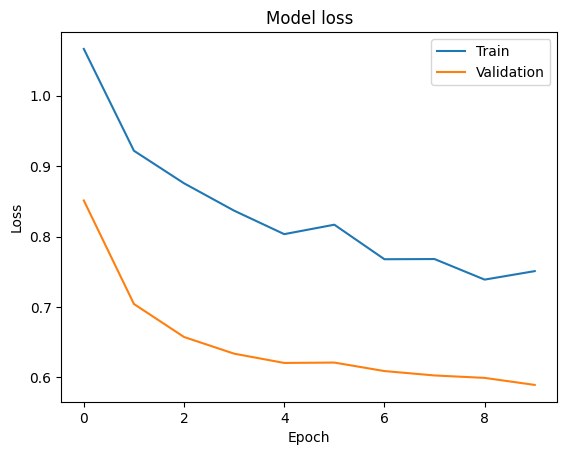

41/41 [==============================] - 2s 51ms/step - loss: 0.5892 - accuracy: 0.7052
Train Accuracy: 78.83527278900146
Test Accuracy: 70.5197811126709
41/41 [==============================] - 2s 52ms/step
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      1361
           1       0.80      0.83      0.81      1644

    accuracy                           0.79      3005
   macro avg       0.79      0.78      0.79      3005
weighted avg       0.79      0.79      0.79      3005

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       623
           1       0.69      0.77      0.73       666

    accuracy                           0.71      1289
   macro avg       0.71      0.70      0.70      1289
weighted avg       0.71      0.71      0.70      1289



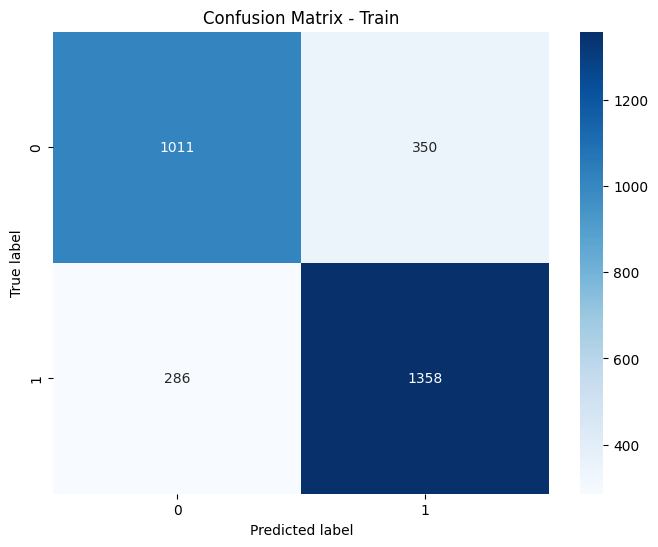

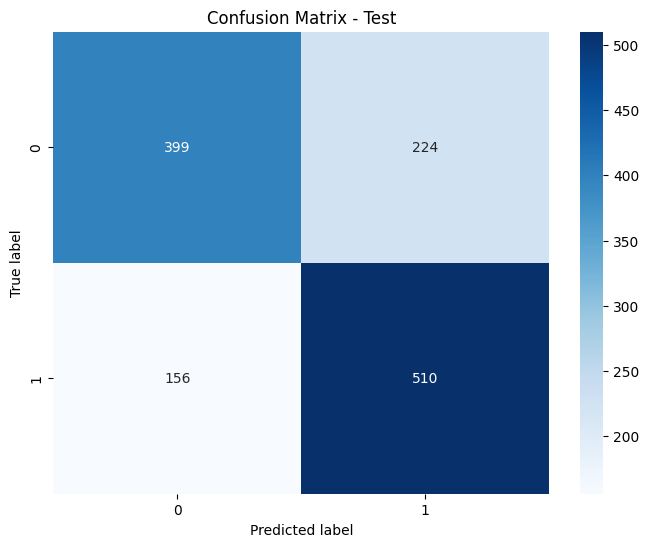

41/41 [==============================] - 2s 53ms/step


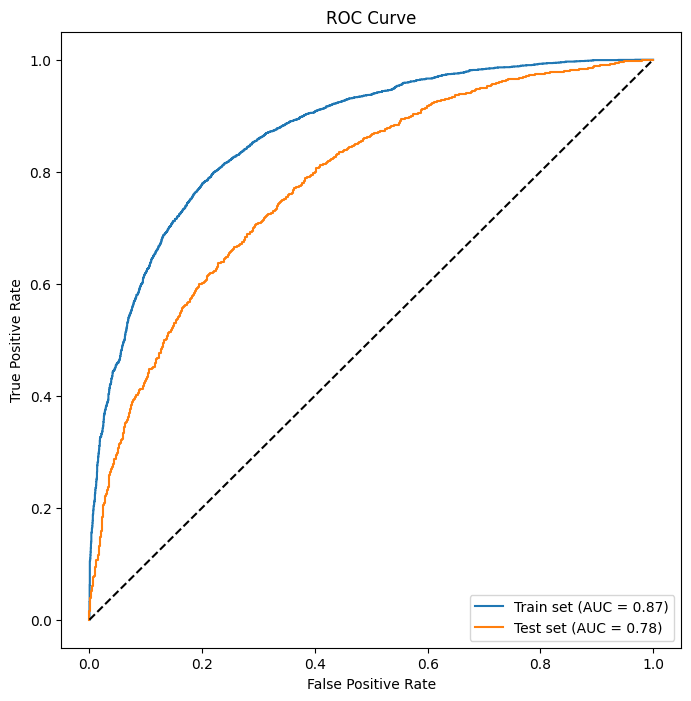

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)
train_accuracy = results_train[1] * 100  # Assuming accuracy is the second element in the results_train tuple/list
test_accuracy = results_test[1] * 100  # Assuming accuracy is the second element in the results_test tuple/list

# Print the evaluation results
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print classification report
pred_train = np.argmax(model.predict(X_train), axis=1)
pred_test = np.argmax(model.predict(X_test), axis=1)
print("Classification Report (Train):\n", classification_report(np.argmax(y_train, axis=1), pred_train))
print("Classification Report (Test):\n", classification_report(np.argmax(y_test, axis=1), pred_test))

# Calculate confusion matrix
cm_train = confusion_matrix(np.argmax(y_train, axis=1), pred_train)
cm_test = confusion_matrix(np.argmax(y_test, axis=1), pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC curve
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())
fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train set (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()